In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import cv2 as cv
import extcolors
import os
from colormap import rgb2hex

In [17]:
def color_to_df(input):
    colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
    df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
    df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
    #convert RGB to HEX code
    df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
                          int(i.split(", ")[1]),
                          int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
    df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
    return df


In [18]:
def exact_color(input_image, tolerance, limit):
    #background
    bg = 'bg.png'
    fig, ax = plt.subplots(figsize=(192,108),dpi=10)
    fig.set_facecolor('white')
    plt.savefig(bg)
    plt.close(fig)
    
    img = Image.open(input_image)

    #crate dataframe
    img_url = input_image
    colors_x = extcolors.extract_from_path(img_url, tolerance = tolerance, limit = limit)
    df_color = color_to_df(colors_x)
    
    #annotate text
    list_color = list(df_color['c_code'])
    list_precent = [int(i) for i in list(df_color['occurence'])]
    text_c = [c + ' ' + str(round(p*100/sum(list_precent),1)) +'%' for c, p in zip(list_color, list_precent)]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(160,120), dpi = 10)
    
    #donut plot
    wedges, text = ax1.pie(list_precent,
                           labels= text_c,
                           labeldistance= 1.05,
                           colors = list_color,
                           textprops={'fontsize': 150, 'color':'black'})
    plt.setp(wedges, width=0.3)

    #add image in the center of donut plot
    img = mpimg.imread(input_image)
    imagebox = OffsetImage(img, zoom = 3)
    ab = AnnotationBbox(imagebox, (0, 0))
    ax1.add_artist(ab)
    
    #color palette
    x_posi, y_posi, y_posi2 = 160, -170, -170
    for c in list_color:
        if list_color.index(c) < 5:
            y_posi += 180
            rect = patches.Rectangle((x_posi, y_posi), 360, 160, facecolor = c)
            ax2.add_patch(rect)
            ax2.text(x = x_posi+400, y = y_posi+80, s = c, fontdict={'fontsize': 190})
        else:
            y_posi2 += 180
            rect = patches.Rectangle((x_posi + 1000, y_posi2), 360, 160, facecolor = c)
            ax2.add_artist(rect)
            ax2.text(x = x_posi+1400, y = y_posi2+80, s = c, fontdict={'fontsize': 190})

    fig.set_facecolor('white')
    ax2.axis('off')
    bg = plt.imread('bg.png')
    plt.imshow(bg)       
    plt.tight_layout()
    return plt.show()

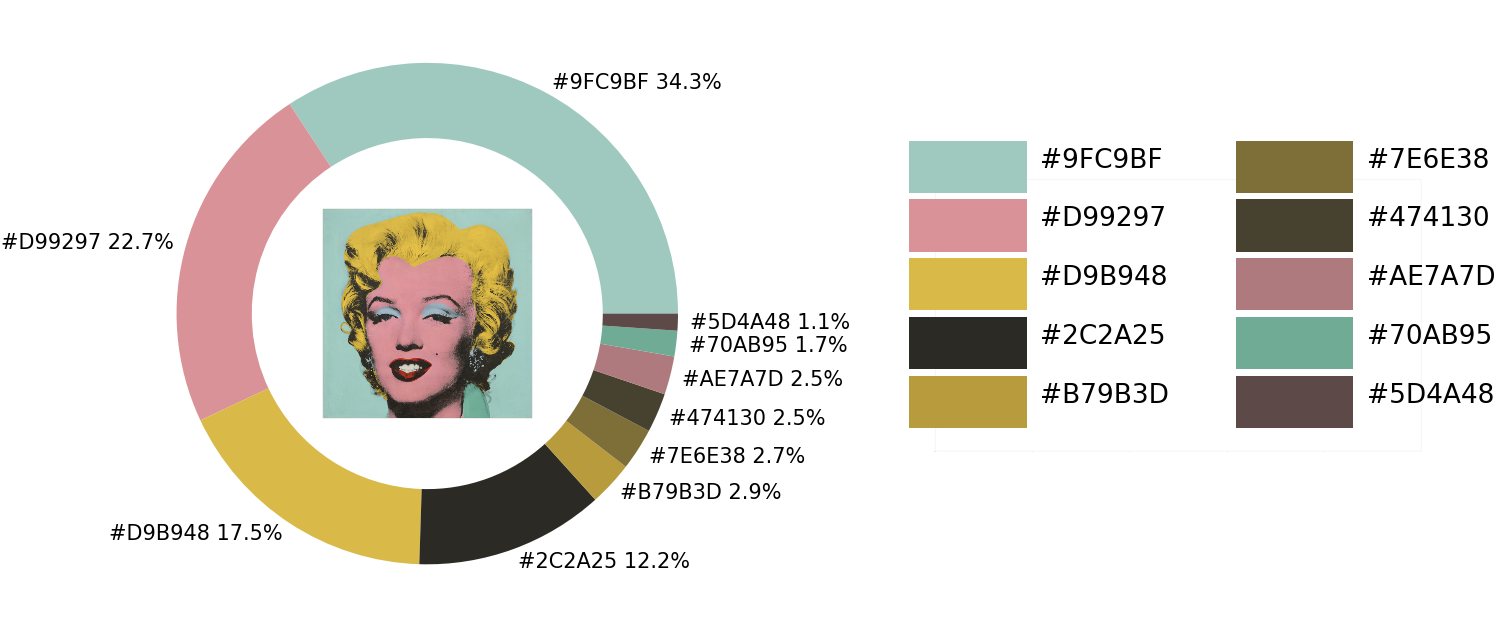

In [23]:
exact_color(input_image=os.getcwd()+'/Image5.png',tolerance=12, limit=11)

# K-mean clustering of the Image

In [28]:
from sklearn.cluster import KMeans

def find_dominant_colors(image_path, num_colors):
    # Load the image
    image = Image.open(image_path)

    # Make sure the image is in RGB format
    image = image.convert("RGB")

    # Convert image data into 2D array of RGB values
    pixels = np.array(image).reshape(-1, 3)

    # Perform K-means clustering to find the most dominant colors
    kmeans = KMeans(n_clusters=num_colors,n_init='auto')
    kmeans.fit(pixels)

    # Get the RGB values of the cluster centers
    colors = kmeans.cluster_centers_

    # These are the dominant colors of the image
    dominant_colors = colors.astype(int)

    # Create a plot with a rectangle (patch) for each color
    plt.figure(figsize=(num_colors * 2, 4), dpi=100)
    plt.suptitle('Dominant colors in image5', y=0.9)

    for i, color in enumerate(dominant_colors):
        plt.subplot(1, num_colors, i+1)
        color_patch = np.zeros((50, 50, 3), dtype=np.uint8)
        color_patch[:, :, :] = color
        plt.imshow(color_patch)
        plt.axis("off")
        plt.title(f'RGB: {color[0]}, {color[1]}, {color[2]}', rotation='horizontal', y=1)

    plt.tight_layout()
    plt.show()

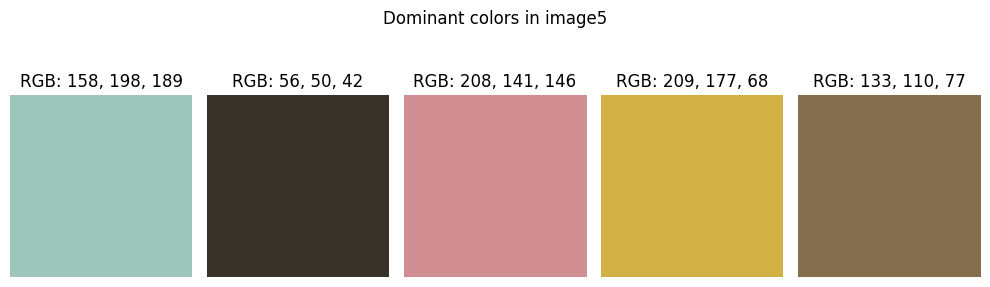

In [29]:
find_dominant_colors(os.getcwd()+'/image5.png', 5)

# Otsu's Method for seperating the background and foreground of the image

In [30]:
from skimage import io, filters

def separate_image(image_path):
    # Load the image
    image = io.imread(image_path, as_gray=True)

    # Apply Otsu's thresholding method
    threshold_value = filters.threshold_otsu(image)

    # Generate the foreground and background images
    foreground = np.where(image > threshold_value, 1, 0)
    background = np.where(image > threshold_value, 0, 1)

    # Plot the original image, foreground, and background
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(foreground, cmap='gray')
    axes[1].set_title('Foreground')
    axes[2].imshow(background, cmap='gray')
    axes[2].set_title('Background')

    for ax in axes:
        ax.axis('off')

    plt.show()


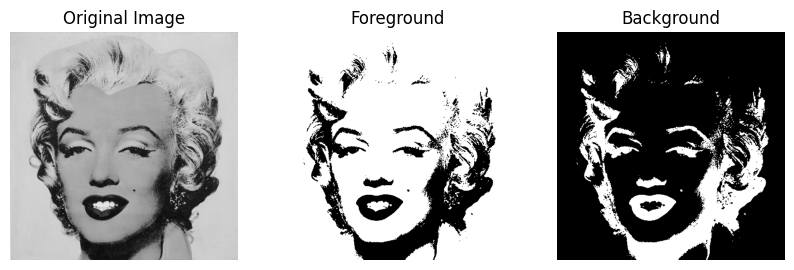

In [35]:
separate_image(os.getcwd()+'/image1.png')

In [50]:
def otsu_thresholding(file_path):
    img = cv.imread(file_path, cv.IMREAD_GRAYSCALE)
    assert img is not None, f"The file at {file_path} could not be read, please check if the path is correct and the file exists."

    # Otsu's thresholding after Gaussian filtering 
    blur = cv.GaussianBlur(img,(5,5),0)
    ret2,th2 = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

    # plot the images
    images = [blur, th2]
    titles = ['Gaussian filtered Image', "Otsu's Thresholding"]

    plt.figure(figsize=(10, 5))

    for i in range(2):
        plt.subplot(1,2,i+1),plt.imshow(images[i],'gray')
        plt.title(titles[i]), plt.xticks([]), plt.yticks([])

    plt.suptitle("Otsu's method for image 5")
    plt.tight_layout()
    plt.show()

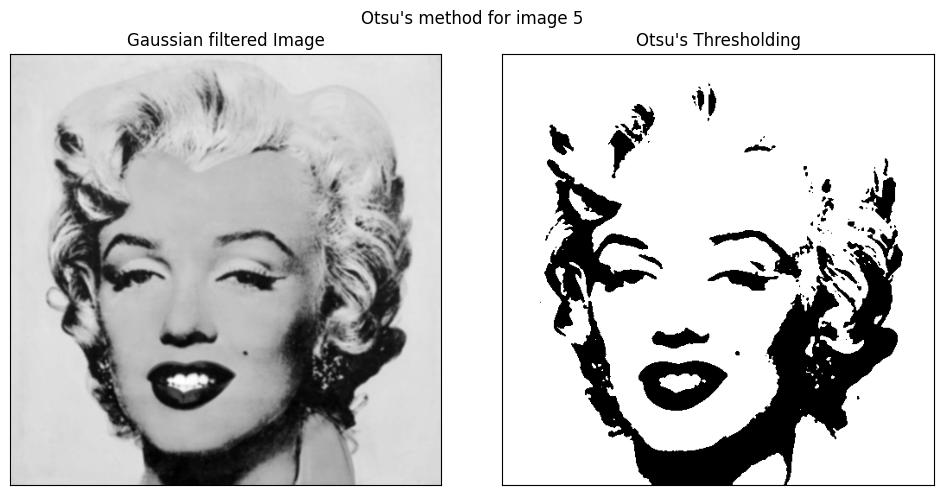

In [51]:
otsu_thresholding(os.getcwd()+'/image5.png')